# Predicting Cell Behavior from Cell Morphology during Cell-Cell Shear

### ECE594N HW Shapes 

__Samuel Feinstein, Amil Khan, Lauren Washington, Alice Mo__

- __Sam__ provided the idea of the project, data, and pre-processing of the data
- __Amil__ built the dictionary representation, wrote helper functions, and performed cell analysis
- __Lauren__ provided the idea of using SRV, and provided initial visualizations
- __Alice__ lead the entire visualization portion

As a side note, our first initials are one letter away from SALAD.

---

#### Data Source

> Ehsan Sadeghipour, Miguel A Garcia, William James Nelson, Beth L Pruitt (2018) Shear-induced damped oscillations in an epithelium depend on actomyosin contraction and E-cadherin cell adhesion eLife 7:e39640 https://doi.org/10.7554/eLife.39640

Confluent MDCK cells on a MEMS device with segmentation by Cellpose 

📸 Images from Liam Dow

---

In [45]:
#plt.figure(figsize=(12, 12))
#plt.imshow(skimage.io.imread("figs/Cropped_Regions@4x.png"))
#plt.axis("off")

# Graphical Abstract
<br> 
<br> 
<!-- <center><img src="figs/Graphical_Abstract_V1@4x.png" width=800px alt="default"/></center> -->
<br> 
<!-- <center>Image from Liam Dow </center> -->

In [46]:
#plt.figure(figsize=(12, 12))
#plt.imshow(skimage.io.imread("figs/Graphical_Abstract_V1@4x.png"))
#plt.axis("off")

# Introduction and Motivation

Cell-cell shear, or the action of cells sliding past each other, has roles in development, disease, and wound healing. Throughout development cells are moving past each other in every stage of development. These biomechanical cues have influences on differentiation, cell shape, behavior, the proteome, and the transcriptome. Previous research on shear focused on fluid shear so in this paper they focused on cell-cell shear which has been well characterized. Epithelial cells known as MDCK cells were used on a MEMS device which can be precisely displaced to create consistent cell-cell shear forces. Using new segmentation and machine learning techniques we are reanalyzing the data to use the changes in cell shape to predict cell behavior/migration.
<br> 
<br> 
<!-- <center><img src="figs/Shear_schematic@4x.png" width=800px alt="default"/></center>
<br> 
<center>Schematic of the Shear Device from Liam Dow </center> -->

In [47]:
#plt.figure(figsize=(12, 12))
#plt.imshow(skimage.io.imread("figs/Shear_schematic@4x.png"))
#plt.axis("off")

## Install and Import Packages
If you run into any issues involving `ModuleNotFoundError: No module named 'geomstats'`, then run the first cell below. Otherwise, run the second one and you should be good to go!

In [48]:
%%bash
# conda install scikit-image pandas matplotlib
# conda install -y "jupyterlab>=3" "ipywidgets>=7.6"
# pip install geomstats read-roi


In [49]:
import numpy as np
import skimage
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.geometry.discrete_curves import DiscreteCurves
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean

# OPTIONAL, needed if using raw data, not our preprocessed dictionary
#from read_roi import read_roi_file
#from read_roi import read_roi_zip



plt.rcParams["figure.dpi"] = 100
%config InlineBackend.figure_format='retina'

# Large-Scale Cell Analysis

---

## Load Data

Here we define large-scale to mean >1K cells, simply because this is when our MacBook Pros started taking several minutes for certain computations. So we switched to a more powerful machine (32 Cores, 128GB RAM) to process and analyze the data. 

#### 🚨 ATTENTION 🚨
If you are trying to run our analysis, you need to download the data from the original paper. Once downloaded, run the dictionary building portion, and save the data using the provided `JSON` code. You can reach out to us for the processed data as well. We are currently not hosting it anywhere. 

```
├── 01082017_ECR_10x__0minstart_aftershear__30secintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       ├── Bottom_plank_1
│       ├── Bottom_plank_2
│       ├── Top_plank_0
│       ├── Top_plank_1
│       └── Top_plank_2
├── 01082017_ECR_10x__15minstart_beforeshear__30secintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       ├── Bottom_plank_1
│       ├── Bottom_plank_2
│       ├── Top_plank_0
│       ├── Top_plank_1
│       └── Top_plank_2
├── 01082017_ECR_10x__30minstart_aftershear__5minintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       ├── Bottom_plank_1
│       ├── Bottom_plank_2
│       ├── Top_plank_0
│       ├── Top_plank_1
│       └── Top_plank_2
└── 01082017_ECR_10x__60minstart_beforeshear__5minintervals_1
    └── Cropped_Images
        ├── Bottom_plank_0
        ├── Bottom_plank_1
        ├── Bottom_plank_2
        ├── Top_plank_0
        ├── Top_plank_1
        └── Top_plank_2

32 directories, 0 files
```

### Visualizing the Entire Folder Structure

🚨 __This is not even all of it.__ The metadata was stored in the folder and file names which we needed to preserve. Otherwise, we would have a jumbled mess of timepoints with no way to map back. 

Within each ROI folder, there were 61 ROI files for 61 images corresponding to different timepoints. 1 ROI file had on average 130 segmented cells. This was one of the major hurdles when determining how to represent the data, which we eventually went with the dictionary format.

Hence, if we take conservative estimates, we have, 

$$61 \text{ (Images)} \times 130 \text{ (AVG Cells) } \times 24 \text{ (Folders)} = 187,200$$

```
.
├── 01082017_ECR_10x__0minstart_aftershear__30secintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Bottom_plank_1
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Bottom_plank_2
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Top_plank_0
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Top_plank_1
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       └── Top_plank_2
│           ├── Averaged ROI Data
│           ├── Data
│           ├── Data_Filtered
│           ├── Labels
│           ├── OG
│           ├── Outlines
│           └── ROIs
├── 01082017_ECR_10x__15minstart_beforeshear__30secintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       │   ├── Averaged_ROI
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Bottom_plank_1
│       │   ├── Averaged_ROI
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Bottom_plank_2
│       │   ├── Averaged_ROI
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Top_plank_0
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Top_plank_1
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       └── Top_plank_2
│           ├── Averaged ROI Data
│           ├── Data
│           ├── Data_Filtered
│           ├── Labels
│           ├── OG
│           ├── Outlines
│           └── ROIs
├── 01082017_ECR_10x__30minstart_aftershear__5minintervals_1
│   └── Cropped_Images
│       ├── Bottom_plank_0
│       │   ├── Averaged_ROI
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Bottom_plank_1
│       │   ├── Averaged_ROI
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Bottom_plank_2
│       │   ├── Averaged_ROI
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Top_plank_0
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       ├── Top_plank_1
│       │   ├── Averaged ROI Data
│       │   ├── Data
│       │   ├── Data_Filtered
│       │   ├── Labels
│       │   ├── OG
│       │   ├── Outlines
│       │   └── ROIs
│       └── Top_plank_2
│           ├── Averaged ROI Data
│           ├── Data
│           ├── Data_Filtered
│           ├── Labels
│           ├── OG
│           ├── Outlines
│           └── ROIs
└── 01082017_ECR_10x__60minstart_beforeshear__5minintervals_1
    └── Cropped_Images
        ├── Bottom_plank_0
        │   ├── Averaged_ROI
        │   ├── Data
        │   ├── Data_Filtered
        │   ├── Labels
        │   ├── OG
        │   ├── Outlines
        │   └── ROIs
[ ... ]

200 directories, 0 files
```
---

# Visualize the Data 

This section is dedicated to the data visualization portion of our report. We needed to understand what the cells look like, if we could see the boundaries with our eyes, and the quality of the labels/ROIs. When we say ROIs, we mean the segmentation of the cells in `x-y` coordinate form.

Here we use `matplotlib` to visualize a raw image from our dataset. We plotted the centers of each labeled cell using `data`.

In [50]:
#plt.imshow(img)
#plt.scatter(data.X, data.Y, c='black', s=0.25, edgecolors='white')


## Visualizing the difference between 1 and 30

In [51]:
img2   = skimage.io.imread("OG/BP-01_img_000000030_TXR_000.tif")
data2  = pd.read_csv("Data/BP-01_img_000000030_TXR_000_Erosion_0px_Channel_1.csv")
plt.imshow(img2)
plt.scatter(data.X, data.Y, c='black', s=0.25, edgecolors='white')
plt.scatter(data2.X, data2.Y, c='black', s=0.25, edgecolors='red')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sfeinstein\\code\\cells\\cells\\notebooks\\PredictingCellShear\\OG\\BP-01_img_000000030_TXR_000.tif'

#### 📕 NOTE

The red dots represent the position at time 30. Some have a significant change when comparing from the initial white point. 

## Visualize the ROI
The `roi` is loaded as an `OrderedDict`. What this means is the dictionary, or key-value pairs, are ordered. For us, its from 001 to $N$ where $N$ represents the number of labeled cells.

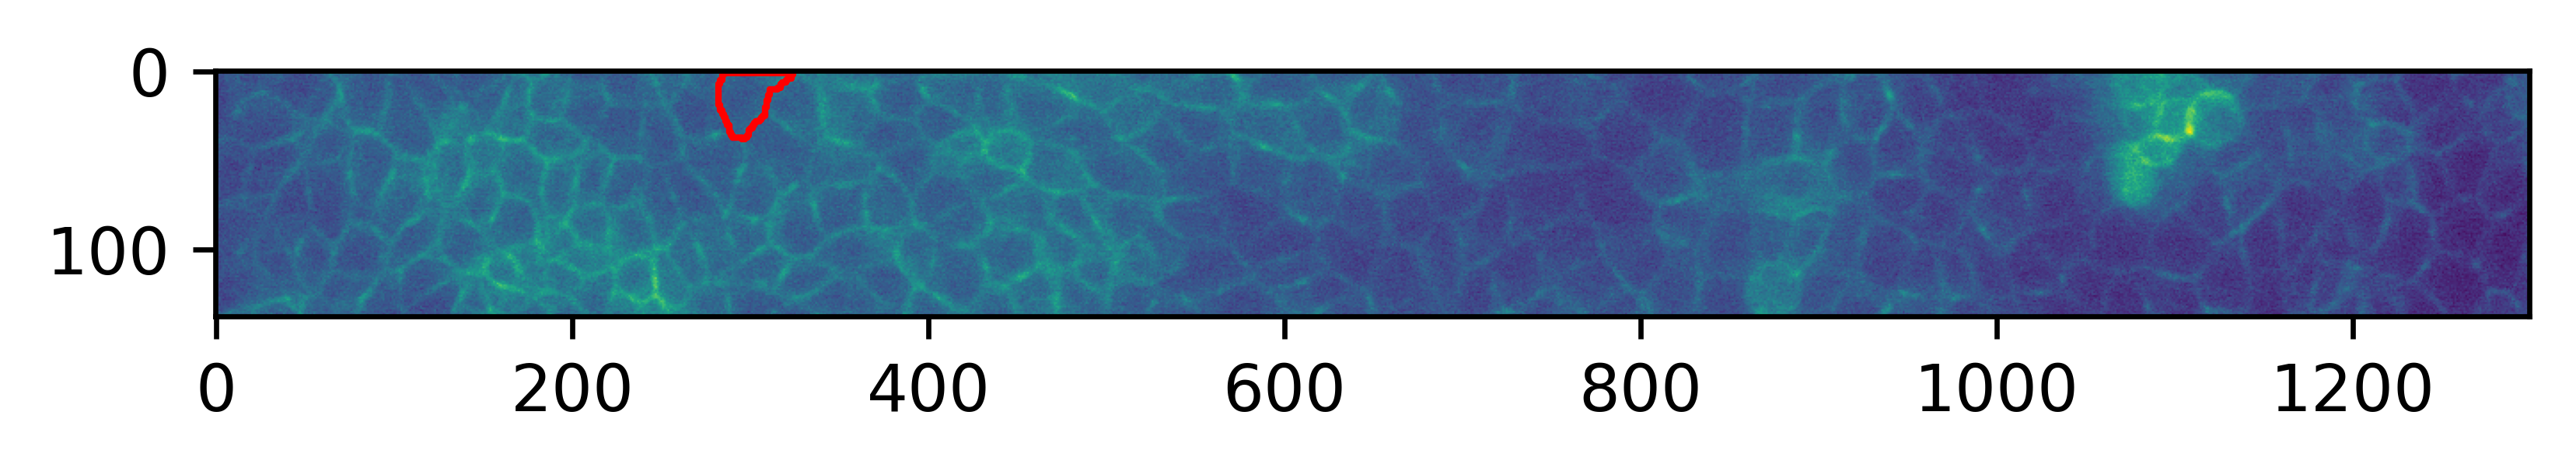

In [ ]:
plt.imshow(img)
plt.plot(roi['019']['x'], roi['019']['y'], c='red', linewidth=1)

## Plotting ROIs at a specific index at different times (no shear)

Text(0.5, 1.0, 'ROI index 40')

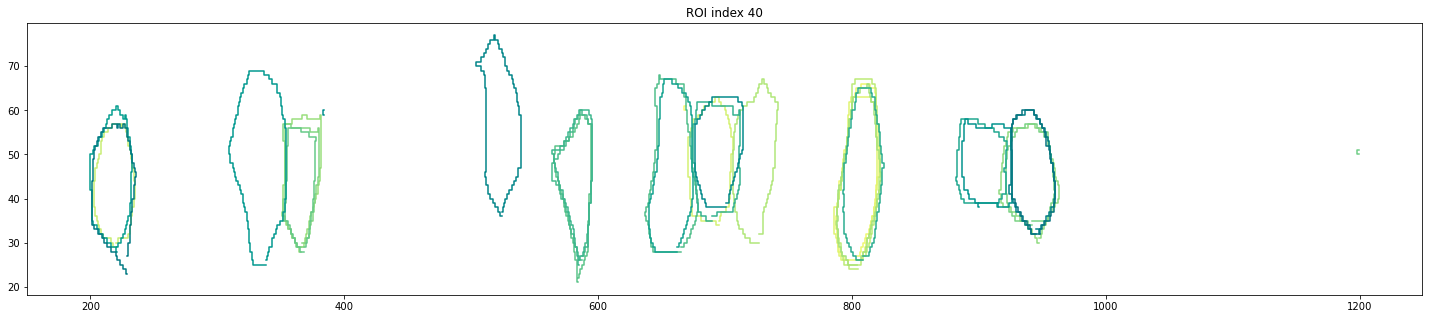

In [ ]:
#Raw data for a single ROI index at different time points
a = 80
fig = plt.figure(figsize=(25, 5))

for key in ex_test:
    if a == 0:
        exit
    else:
        imgtest = get_curve(ex_test[key])
        curve_a = imgtest[40]
        #print(curve_a[:,0])        
        #print(np.mean(curve_a[:,0]))
        #curve_a = preshape.projection(curve_a)
        plt.plot(curve_a[:, 0], curve_a[:, 1])
        a = a - 1
plt.title('ROI index 40')

Text(0.5, 1.0, 'ROI index 39')

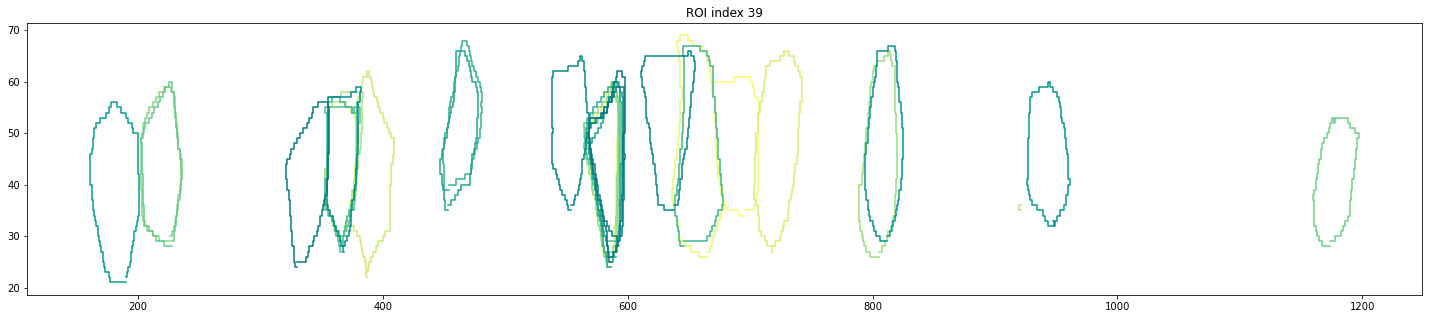

In [ ]:
#Raw data for a single ROI index at different time points
a = 80
fig = plt.figure(figsize=(25, 5))

for key in ex_test:
    if a == 0:
        exit
    else:
        imgtest = get_curve(ex_test[key])
        curve_a = imgtest[39]
        #curve_a = preshape.projection(curve_a)
        plt.plot(curve_a[:, 0], curve_a[:, 1])
        a = a - 1
plt.title('ROI index 39')

# Plotting all ROIs within 15 min interval (no shear)

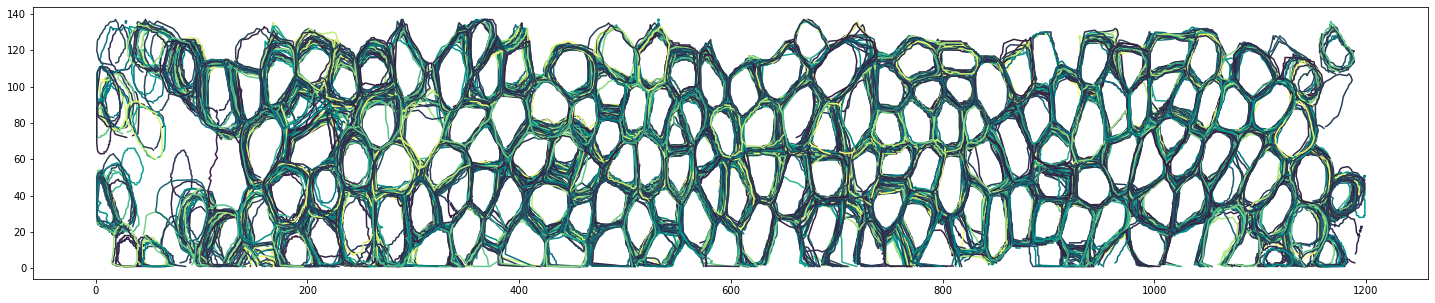

In [ ]:
#Raw data for a single ROI index at different time points
fig = plt.figure(figsize=(25, 5))

data_roi1 = interpolate_dicrete_curve(get_curve(ex_test['TP-01_img_000000015_TXR_000_Erosion_0px_RoiSet'])[40], k_sampling_points)
data_roi2 = interpolate_dicrete_curve(get_curve(ex_test['TP-01_img_000000017_TXR_000_Erosion_0px_RoiSet'])[40], k_sampling_points)
data_roi1 = np.stack((data_roi1, data_roi2))


for key in ex_test:
    imgtest = get_curve(ex_test[key])
    for x in range(len(imgtest)):
            curve_a = imgtest[x]
            curve_a = interpolate_dicrete_curve(curve_a, k_sampling_points)
            if 150 < np.mean(curve_a[:, 0]) < 200 and 50 < np.mean(curve_a[:, 1]) < 80:
                  data_roi1 = np.concatenate((data_roi1, [curve_a]))

            #curve_a = preshape.projection(curve_a)
            #curve_a = 1 / curve_length(curve_a) * curve_a
            plt.plot(curve_a[:, 0], curve_a[:, 1])


The data of the cell has shape (n_times, n_points_on_curve, dim) = (33, 50, 2).


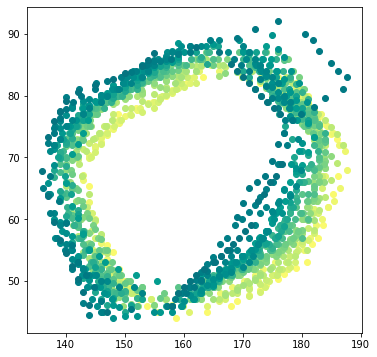

In [ ]:
print(f"The data of the cell has shape (n_times, n_points_on_curve, dim) = {data_roi1.shape}.")

fig = plt.figure(figsize=(6, 6))
data_roi1 = data_roi1[2:]
for i in range(len(data_roi1)):
    a = data_roi1[i]
    plt.plot(a[:, 0], a[:, 1], 'o')
plt.title('Cell Shape across time=Yellow to time=Green')

# Plotting all ROIs within 15 min interval (with shear)

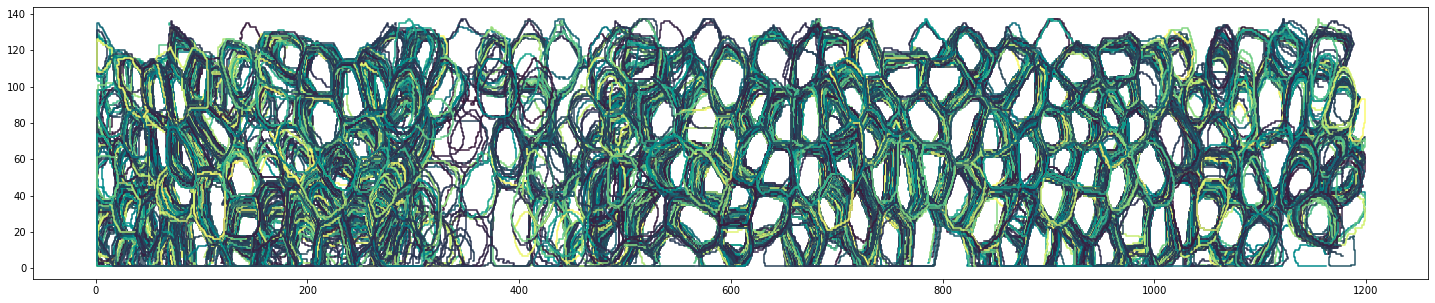

In [ ]:
#After shear

#Raw data for a single ROI index at different time points
a = 80
fig = plt.figure(figsize=(25, 5))

for key in ex_test_shear:
    imgtest = get_curve(ex_test_shear[key])
    for x in range(len(imgtest)):
            curve_a = imgtest[x]
            #curve_a = preshape.projection(curve_a)
            #curve_a = 1 / curve_length(curve_a) * curve_a
            plt.plot(curve_a[:, 0], curve_a[:, 1])


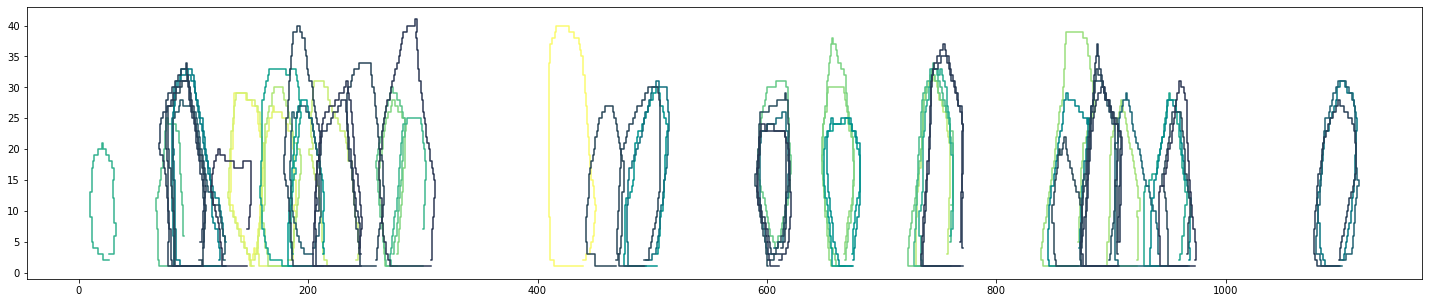

In [ ]:
#Raw data for a single ROI index at different time points
a = 200
fig = plt.figure(figsize=(25, 5))

for key in ex_test_shear:
    if a == 0:
        exit
    else:
        imgtest = get_curve(ex_test_shear[key])
        curve_a = imgtest[5]
        #curve_a = preshape.projection(curve_a)
        plt.plot(curve_a[:, 0], curve_a[:, 1])
        a = a - 1

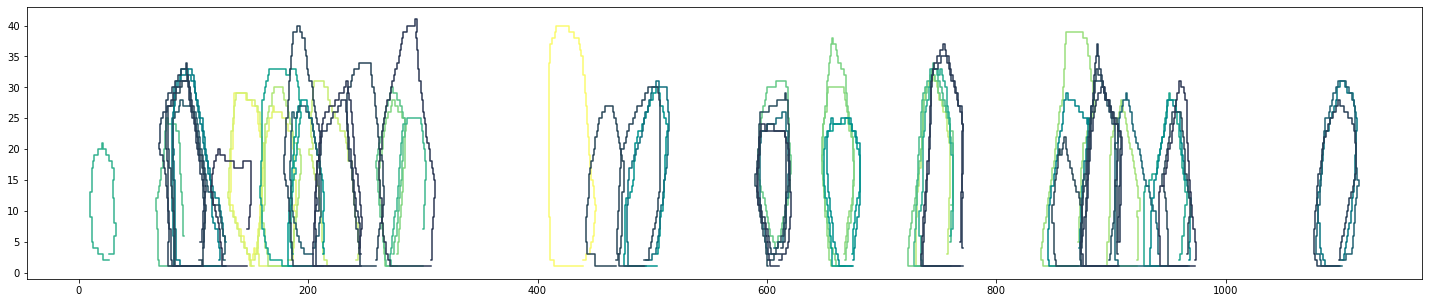

In [ ]:
#Raw data for a single ROI index at different time points
a = 200
fig = plt.figure(figsize=(25, 5))

for key in ex_test_shear:
    if a == 0:
        exit
    else:
        imgtest = get_curve(ex_test_shear[key])
        curve_a = imgtest[5]
        #curve_a = preshape.projection(curve_a)
        plt.plot(curve_a[:, 0], curve_a[:, 1])
        a = a - 1

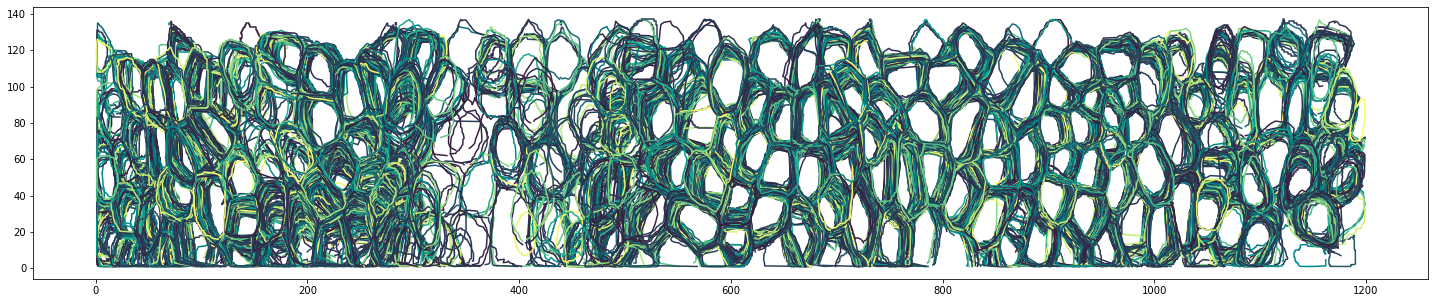

In [ ]:
data_roi1_s = interpolate_dicrete_curve(get_curve(ex_test['TP-01_img_000000015_TXR_000_Erosion_0px_RoiSet'])[40], k_sampling_points)
data_roi2_s = interpolate_dicrete_curve(get_curve(ex_test['TP-01_img_000000017_TXR_000_Erosion_0px_RoiSet'])[40], k_sampling_points)
data_roi1_s = np.stack((data_roi1_s, data_roi2_s))

fig = plt.figure(figsize=(25, 5))

for key in ex_test_shear:
    imgtest = get_curve(ex_test_shear[key])
    for x in range(len(imgtest)):
            #imgtest = get_curve(ex_test['TP-01_img_000000000_TXR_000_Erosion_0px_RoiSet'])
            curve_a = imgtest[x]
            curve_a = interpolate_dicrete_curve(curve_a, k_sampling_points)
            if 175 < np.mean(curve_a[:, 0]) < 210 and 45 < np.mean(curve_a[:, 1]) < 75:
                  data_roi1_s = np.concatenate((data_roi1_s, [curve_a]))

            #curve_a = preshape.projection(curve_a)
            #curve_a = 1 / curve_length(curve_a) * curve_a
            plt.plot(curve_a[:, 0], curve_a[:, 1])


The data of the cell has shape (n_times, n_points_on_curve, dim) = (33, 50, 2).


Text(0.5, 1.0, 'Cell Shape across time from Yellow to Green')

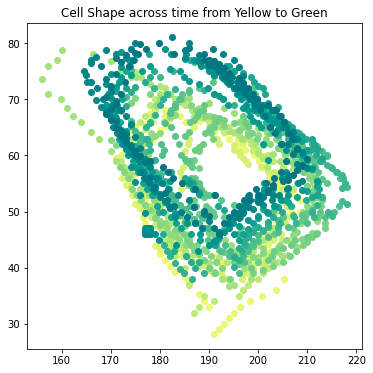

In [ ]:
print(f"The data of the cell has shape (n_times, n_points_on_curve, dim) = {data_roi1_s.shape}.")

fig = plt.figure(figsize=(6, 6))
data_roi1_s = data_roi1_s[2:]
for i in range(len(data_roi1_s)):
    a = data_roi1_s[i]
    plt.plot(a[:, 0], a[:, 1], 'o')
plt.title('Cell Shape across time=Yellow to time=Green')

# 🛠️ Build a Dictionary of all the ROIs

We needed a fast and efficient way to access almost __200K__ cells. So we used the good old `python` dictionary. The reason we went with a dictionary representation was because we needed to preserve the metadata embedded in the folder and file names. We also needed a fast way to retrieve specific data, which was mainly motivated by our downstream plan to build a PyTorch dataloader for further deep learning analysis.




In [ ]:
def build_rois(path: str) -> dict:
    """
    build_rois(path: str)
    
    Given an ROI filepath, extract all the ROIs.
    
    Parameters
    ----------
    path : str
        Filepath to ROIs.
        
    
    Returns
    -------
    out : dict
        A dictionary of all ROIs in a filepath.
    """
    rois = {}
    for roi in sorted(os.listdir(path)):
        # print(roi.split(".")[0])
        rois[roi.split(".")[0]] = read_roi_zip(os.path.join(path,roi))
    return rois


In [ ]:
def dictPath(ogPath: str, path: str, dictionary: dict, sep: str="/"):
    """
    dictPath(ogPath: str, path: str, dictionary: dict, sep: str="/")
    
    Given an ROI filepath, extract all the ROIs within that folder.
    
    Parameters
    ----------
    ogPath : str
        Original file path for data folder.
    path : str
        Needed for recursive call, path is first set as ogPath.
    dictionary: dict
        Dictionary, can be empty or an existing one to add new data to.  
    sep: str
        Seperator for the filepath, most likely will be "/" which is the default.
    
    Returns
    -------
    out : dict
        A dictionary of all ROIs in a filepath.
        
    """
    while path.startswith(sep):
        path = path[1:]
        # print(path)
    parts = path.split(sep, 1)
    if len(parts) > 1:
        branch = dictionary.setdefault(parts[0], {})
        dictPath(ogPath, parts[1], branch, sep)
        if parts[0] == "ROIs":
            dictionary[parts[0]] = build_rois(ogPath)


In [ ]:
dictPath?

Signature: dictPath(ogPath: str, path: str, dictionary: dict, sep: str = '/')
Docstring:
dictPath(ogPath: str, path: str, dictionary: dict, sep: str="/")

Given an ROI filepath, extract all the ROIs within that folder.

Parameters
----------
ogPath : str
    Original file path for data folder.
path : str
    Needed for recursive call, path is first set as ogPath.
dictionary: dict
    Dictionary, can be empty or an existing one to add new data to.  
sep: str
    Seperator for the filepath, most likely will be "/" which is the default.

Returns
-------
out : dict
    A dictionary of all ROIs in a filepath.
    
File:      c:\users\sfeinstein\appdata\local\temp\ipykernel_20360\550681795.py
Type:      function

## Save the Preprocessed Data as JSON

The entire raw folder of data was over 7GB. After our preprocessing, we reduced the data to 270MB.  With this, we can complete a full shape analysis of almost 200K cells.

In [ ]:
# # create json object from dictionary
json = json.dumps(shearData)

# open file for writing, "w" 
f = open("ShearData.json","w")

# write json object to file
f.write(json)

# close file
f.close()

## Open the Preprocessed Data

In [53]:
f = open('C:/Users/sfeinstein/code/cells/cells/notebooks/ShearData.json')
f = json.load(f)

In [75]:
data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs']['BP-01_img_000000057_TXR_000_Erosion_0px_RoiSet'].keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10-1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62-1', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76'])

In [55]:
def get_array_perplank(data_dict: dict, plank: str) -> list:
    """
    Helper function that gets all the cell ROIs for an entire plank.
    
    Parameters
    ----------
    data_dict : dict
        Dictionary of the data that has "ROI" as a key.
    plank : data-type, optional
        The desired data-type for the array, e.g., `numpy.int8`.  Default is
        `numpy.float64`.
    
    Returns
    -------
    out : list
        A list of all ROIs in a plank.
    """
    planks = []
    for img in data_dict[plank]["ROIs"]:
        # print(data_dict[key]["ROIs"][img].keys())
        for cellnum in data_dict[plank]["ROIs"][img].keys():
            stacked = np.column_stack([data_dict[plank]["ROIs"][img][cellnum]['x'], data_dict[plank]["ROIs"][img][cellnum]['y']])
            planks.append(interpolate_dicrete_curve(stacked, 50))
    return planks
        
plks = get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images'], 'Bottom_plank_1')

In [56]:
bottomplk = np.array(plks)

In [57]:
# plt.plot(lst_bpimg1[0][:,0], lst_bpimg1[0][:,1], )
np.array(lst_bpimg1).shape
lst_bpimg1_fnl =  np.reshape(lst_bpimg1, (141, 50*2))

ValueError: cannot reshape array of size 713400 into shape (141,100)

### Displacements 

In [ ]:
ddsam = pd.read_excel("Shear_Mine_Results_Matched_Portions_DD.xlsx")
ddsam

name       time  shear            drug  bottom  proximal_ddarea  \
0           1_8_17  -1.000000  Shear            None     Top         0.000000   
1           1_8_17  -0.916667  Shear            None     Top       -13.164054   
2           1_8_17  -0.833333  Shear            None     Top        -0.513345   
3           1_8_17  -0.750000  Shear            None     Top        22.073203   
4           1_8_17  -0.666667  Shear            None     Top        -6.515818   
...            ...        ...    ...             ...     ...              ...   
8175  11_19_2017    23.666667  Shear  Jasplakinolide  Bottom        -6.064709   
8176  11_19_2017    23.750000  Shear  Jasplakinolide  Bottom         3.008293   
8177  11_19_2017    23.833333  Shear  Jasplakinolide  Bottom        -9.545908   
8178  11_19_2017    23.916667  Shear  Jasplakinolide  Bottom        -9.514214   
8179  11_19_2017    24.000000  Shear  Jasplakinolide  Bottom       -17.243421   

      proximal_ddroi  proximal_ddratio  proximal_ddcircularity  \
0                0.0          0.000000                0.000000   
1              -12.0          0.004867                0.000297   
2              -27.0         -0.027291                0.030952   
3               47.0          0.065549               -0.048343   
4                7.0          0.078220                0.003295   
...              ...               ...                     ...   
8175            -1.0          0.047845               -0.006414   
8176           -17.0         -0.015717               -0.003063   
8177           -10.0          0.002845                0.003365   
8178            23.0          0.041532                0.003733   
8179           -32.0         -0.070972                0.021941   

      proximal_ddperimeter  ...  middle_displacement  middle_dd_displacement  \
0                 0.000000  ...             0.000000                0.000000   
1                -1.886994  ...            -0.628647               -0.628647   
2                -1.033225  ...            -0.929561               -0.300914   
3                 4.670677  ...            -1.189906               -0.260345   
4                -1.023538  ...            -1.237177               -0.047271   
...                    ...  ...                  ...                     ...   
8175             -0.536262  ...           -11.973938                0.325228   
8176              0.506154  ...           -11.698106                0.275832   
8177             -1.371136  ...           -11.417896                0.280210   
8178             -1.400567  ...           -11.287539                0.130357   
8179             -3.108556  ...           -10.910303                0.377236   

      distal_ddarea  distal_ddroi  distal_ddratio  distal_ddcircularity  \
0          0.000000           0.0        0.000000              0.000000   
1         -9.495638           7.0       -0.004541              0.004620   
2        -22.451747         -15.0       -0.058031              0.032468   
3         22.657575          27.0        0.098008             -0.037732   
4          2.756820         -12.0        0.003300             -0.004166   
...             ...           ...             ...                   ...   
8175      -3.262572          -8.0       -0.035564              0.011180   
8176       1.709695           4.0        0.058764             -0.013830   
8177      -1.455126          -8.0       -0.065744              0.004982   
8178     -12.442968           7.0       -0.000886              0.013737   
8179     -10.832451         -36.0        0.011670             -0.001835   

      distal_ddperimeter  distal_ddq  distal_displacement  \
0               0.000000    0.000000             0.000000   
1              -1.336112   -0.012238            -0.738280   
2              -4.086593   -0.082982            -1.087978   
3               4.347524    0.096936            -1.375425   
4               0.519325    0.011144            -1.525908   
...                 

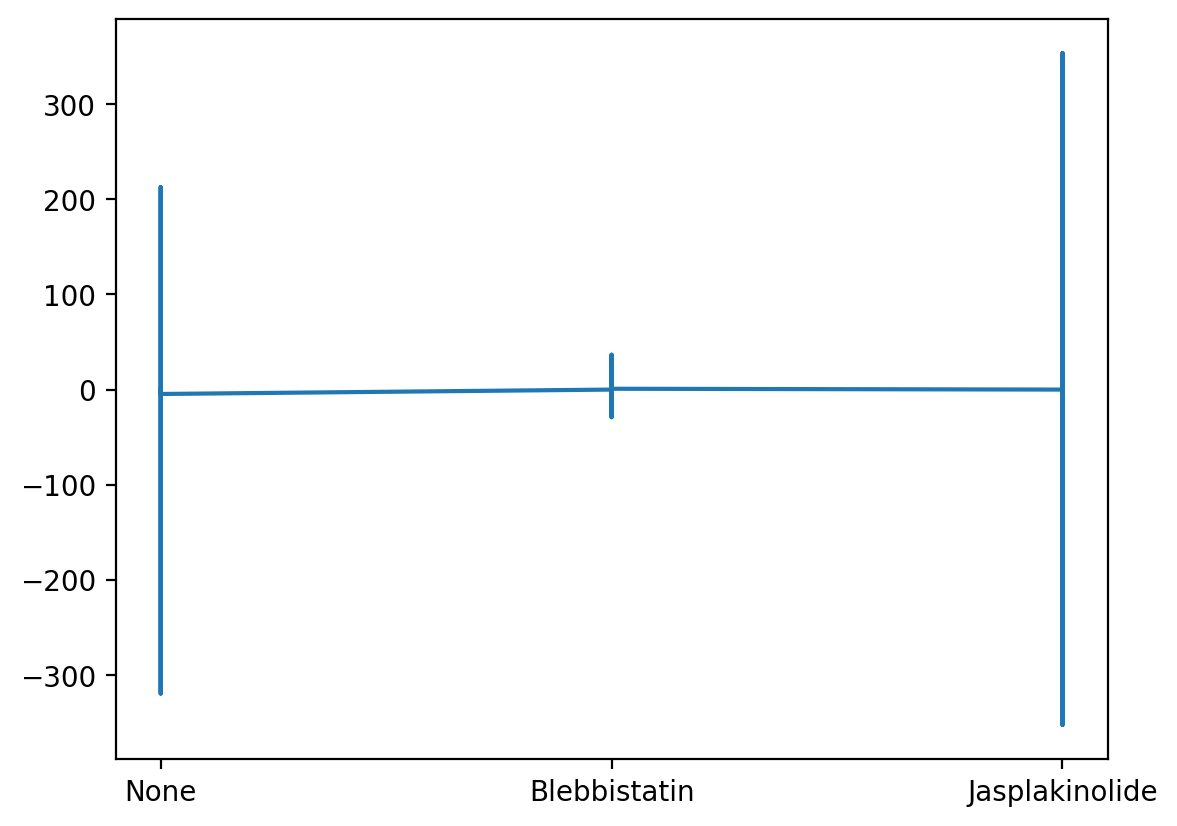

In [ ]:
plt.plot(ddsam.drug, ddsam.proximal_ddarea)

---
# Geomstats for Cell Shape Analysis

We apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the $\ell_2$ distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`.

We can compute geodesics between discrete curves with respect to the elastic metric. In our data, these geodesics represent trajectories between cell boundaries that minimize an elastic energy, and the length of the geodesic defines a distance between curves. We illustrate such a geodesic between two cells.

In [58]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=50)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_space.metric


def exhaustive_align(curve, base_curve):
    """
    Align curve to base_curve to minimize the L² distance.
    
    Parameters
    ----------
    curve : array
    
    base_curve : array

    Returns
    -------
    aligned_curve : discrete curve
    
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve


In [59]:
aligned = []
for lst in bottomplk:
    prshape = PRESHAPE_SPACE.projection(lst)
    aligned.append(exhaustive_align(prshape, lst_bpimg1[0]))

In [60]:
gs.array(aligned).shape

(7134, 50, 2)

Text(0.5, 1.0, 'Aligned curve')

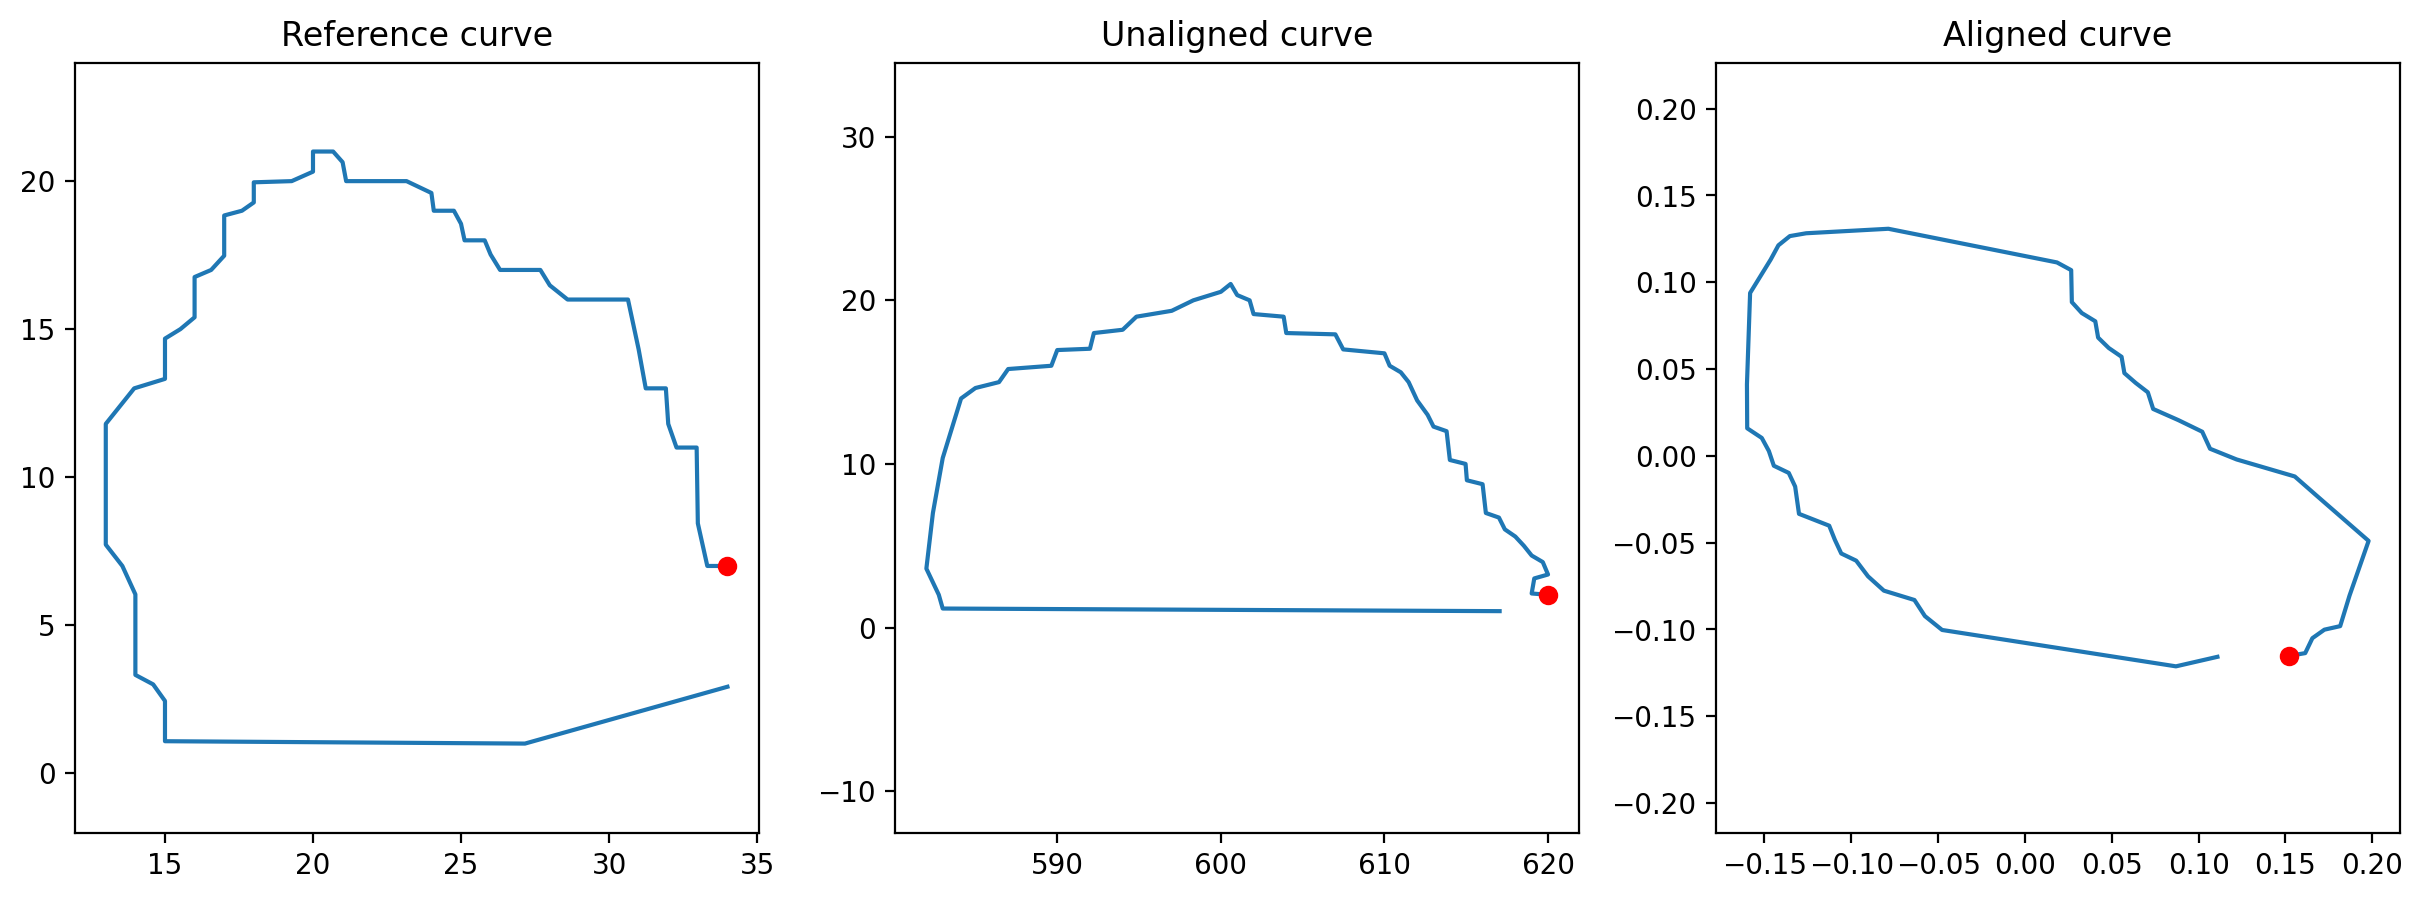

In [61]:
BASE_CURVE=lst_bpimg1[0]
unaligned_cell = lst_bpimg1[1]
aligned_cell = aligned[7]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

Next, we will use the `SRVMetric`, an Elastic metric defined using the Square Root Velocity Function.

In [65]:
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.metric

geodesic = SRV_METRIC.geodesic(initial_point=aligned[0], end_point=aligned[-1])

n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
geod_points = geodesic(times)

In [67]:
FrechetMean?

Init signature:
FrechetMean(
    metric,
    max_iter=32,
    epsilon=0.0001,
    method='default',
    init_point=None,
    init_step_size=1.0,
    verbose=False,
)
Docstring:     
Empirical Frechet mean.

Parameters
----------
metric : RiemannianMetric
    Riemannian metric.
max_iter : int
    Maximum number of iterations for gradient descent.
    Optional, default: 32.
epsilon : float
    Tolerance for stopping the gradient descent.
    Optional, default : 1e-4
method : str, {\'default\', \'adaptive\', \'batch\'}
    Gradient descent method.
    The `adaptive` method uses a Levenberg-Marquardt style adaptation of
    the learning rate. The `batch` method is similar to the default
    method but for batches of equal length of samples. In this case,
    samples must be of shape [n_samples, n_batch, *metric.shape].
    Optional, default: \'default\'.
init_point : array-like, shape=[*metric.shape]
    Initial point.
    Optional, default : None. In this case the first sample of the inpu

In [68]:
mean = FrechetMean(metric=SRV_METRIC, method="default")
mean.fit(gs.array(aligned))

mean_estimate = mean.estimate_

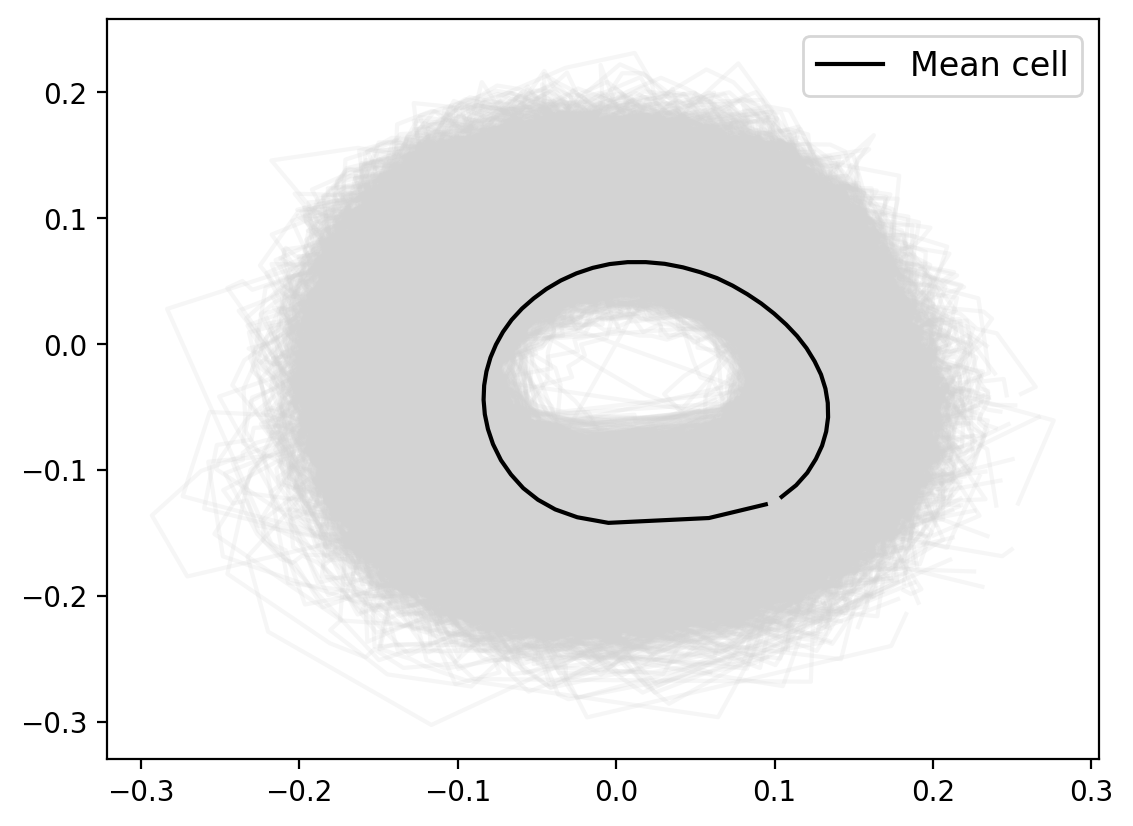

In [69]:
for cell in aligned:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)
    
plt.plot(
    mean_estimate[:, 0], mean_estimate[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

In [ ]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate_dicrete_curve(mean_estimate_clean, 50)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(50, 2)
0
(50, 2)


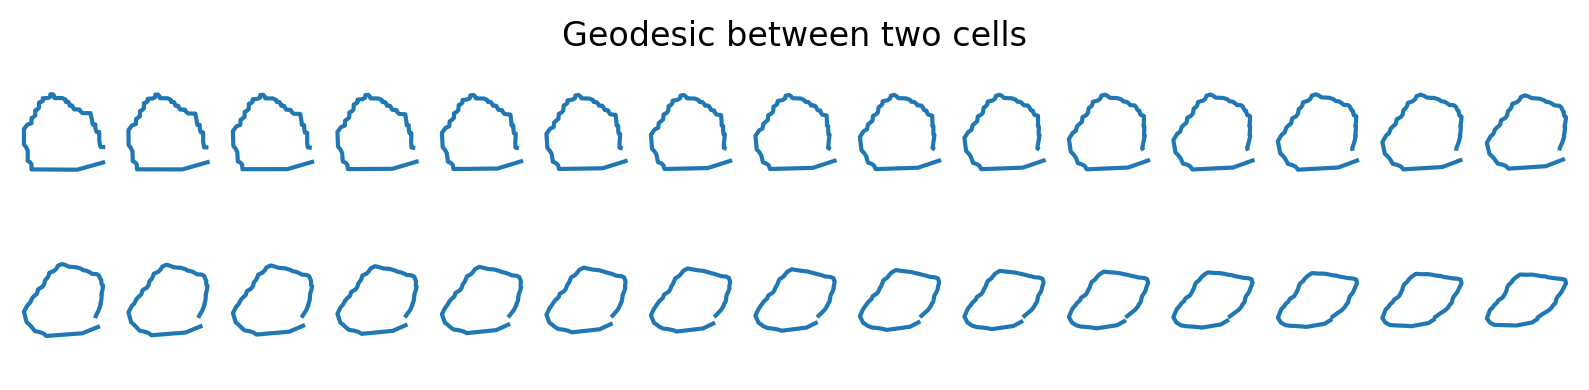

In [ ]:
fig = plt.figure(figsize=(10, 2))
plt.title("Geodesic between two cells")
plt.axis("off")

for i, curve in enumerate(geod_points):
    fig.add_subplot(2, n_times // 2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis("equal")
    plt.axis("off")
plt.savefig('geotwocells.png')

Here we the show the geodesic, which is a trajectory in the space of curves, between the two selected cells.

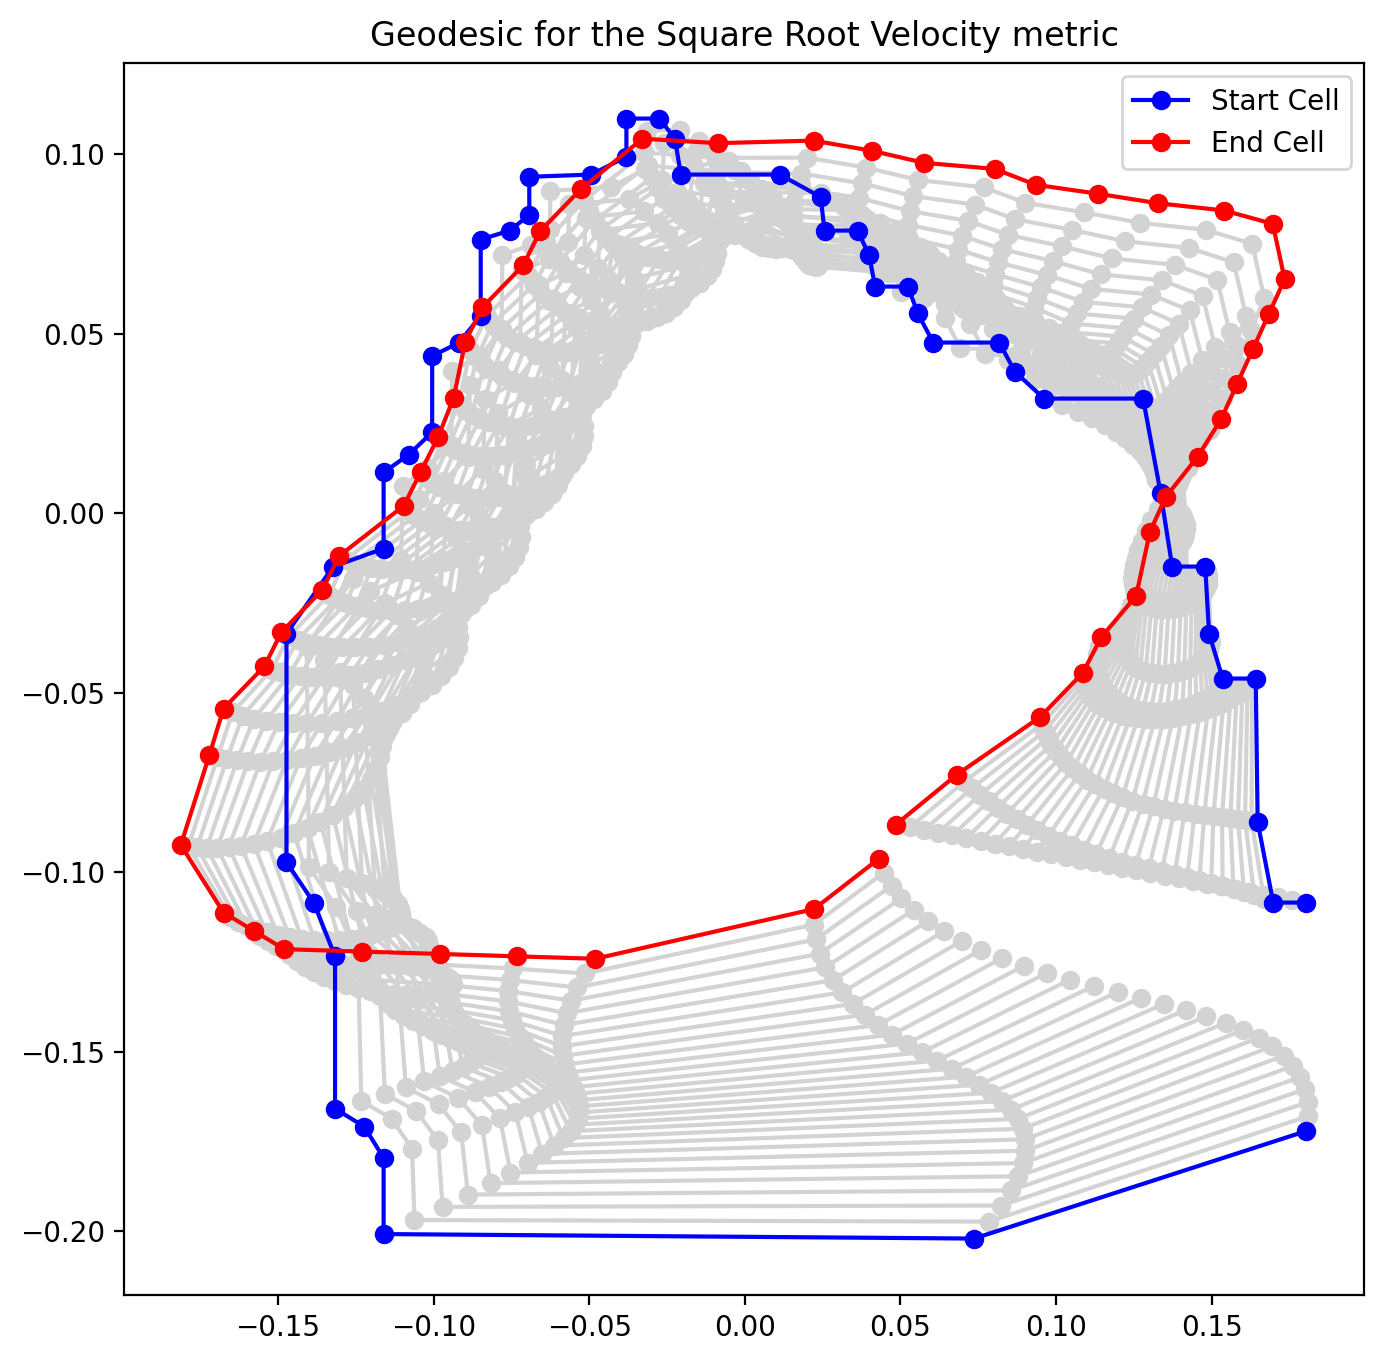

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(1, n_times - 1):
    plt.plot(geod_points[i, :, 0], geod_points[i, :, 1], "o-", color="lightgrey")
plt.plot(geod_points[0, :, 0], geod_points[0, :, 1], "o-b", label="Start Cell")
plt.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], "o-r", label="End Cell")

plt.title("Geodesic for the Square Root Velocity metric")
plt.legend()
plt.show()

### Helper Functions for Plotting

In [ ]:
def vis_roi(img, roi: dict, cellNum: str ):
    """
    Visualize Entire Image and ROI
    
    PARAMS
    ------
    
    img: ARRAY
        raw image to visualize
    
    roi: DICT  
        Region of Interest to visualize
    
    cellNum: STRING 
        Which cell number to visualize
    
    
    RETURNS
    ------
    
    Matplotlib plot with roi overlayed on raw image.
    
    """
    if len(cellNum) < 3:
        raise Exception("Cell Number requires three digit (000) format, i.e., 019.")
    print("-"*30)
    print(f'Choose from 001 to {len(roi)}')
    print(f'Selected: Cell Label {cellNum}')
    print("-"*30)
    plt.imshow(img)
    plt.plot(roi[str(cellNum)]['x'], roi[str(cellNum)]['y'], c='red', linewidth=1)

------------------------------
Choose from 001 to 196
Selected: Cell Label 009
------------------------------


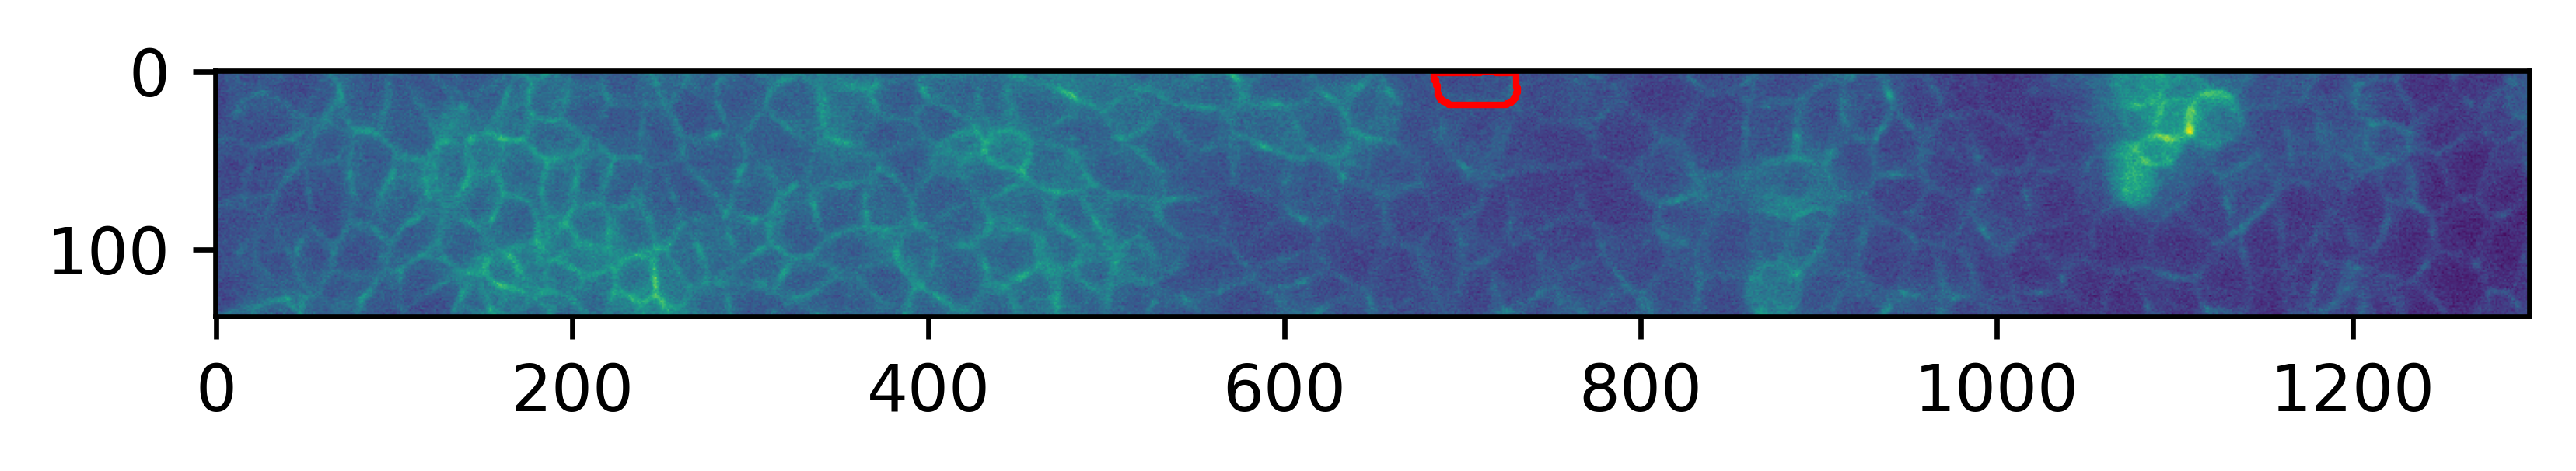

In [ ]:
vis_roi(img, roi, '009')

In [ ]:
def roiContour(roi: dict, cellNum: str ):
    """
    Visualize ONLY ROI
    
    PARAMS
    ------
    
    
    roi: DICT  
        Region of Interest to visualize
    
    cellNum: STRING 
        Which cell number to visualize
    
    
    RETURNS
    ------
    
    Matplotlib Line plot for ROI
    
    """
    print("-"*30)
    print(f'Choose from 001 to {len(roi)}')
    print(f'Selected: Cell Label {cellNum}')
    print("-"*30)
    # plt.imshow(img)
    plt.plot(roi[str(cellNum)]['x'], roi[str(cellNum)]['y'], c='red', linewidth=1)

------------------------------
Choose from 001 to 196
Selected: Cell Label 001
------------------------------


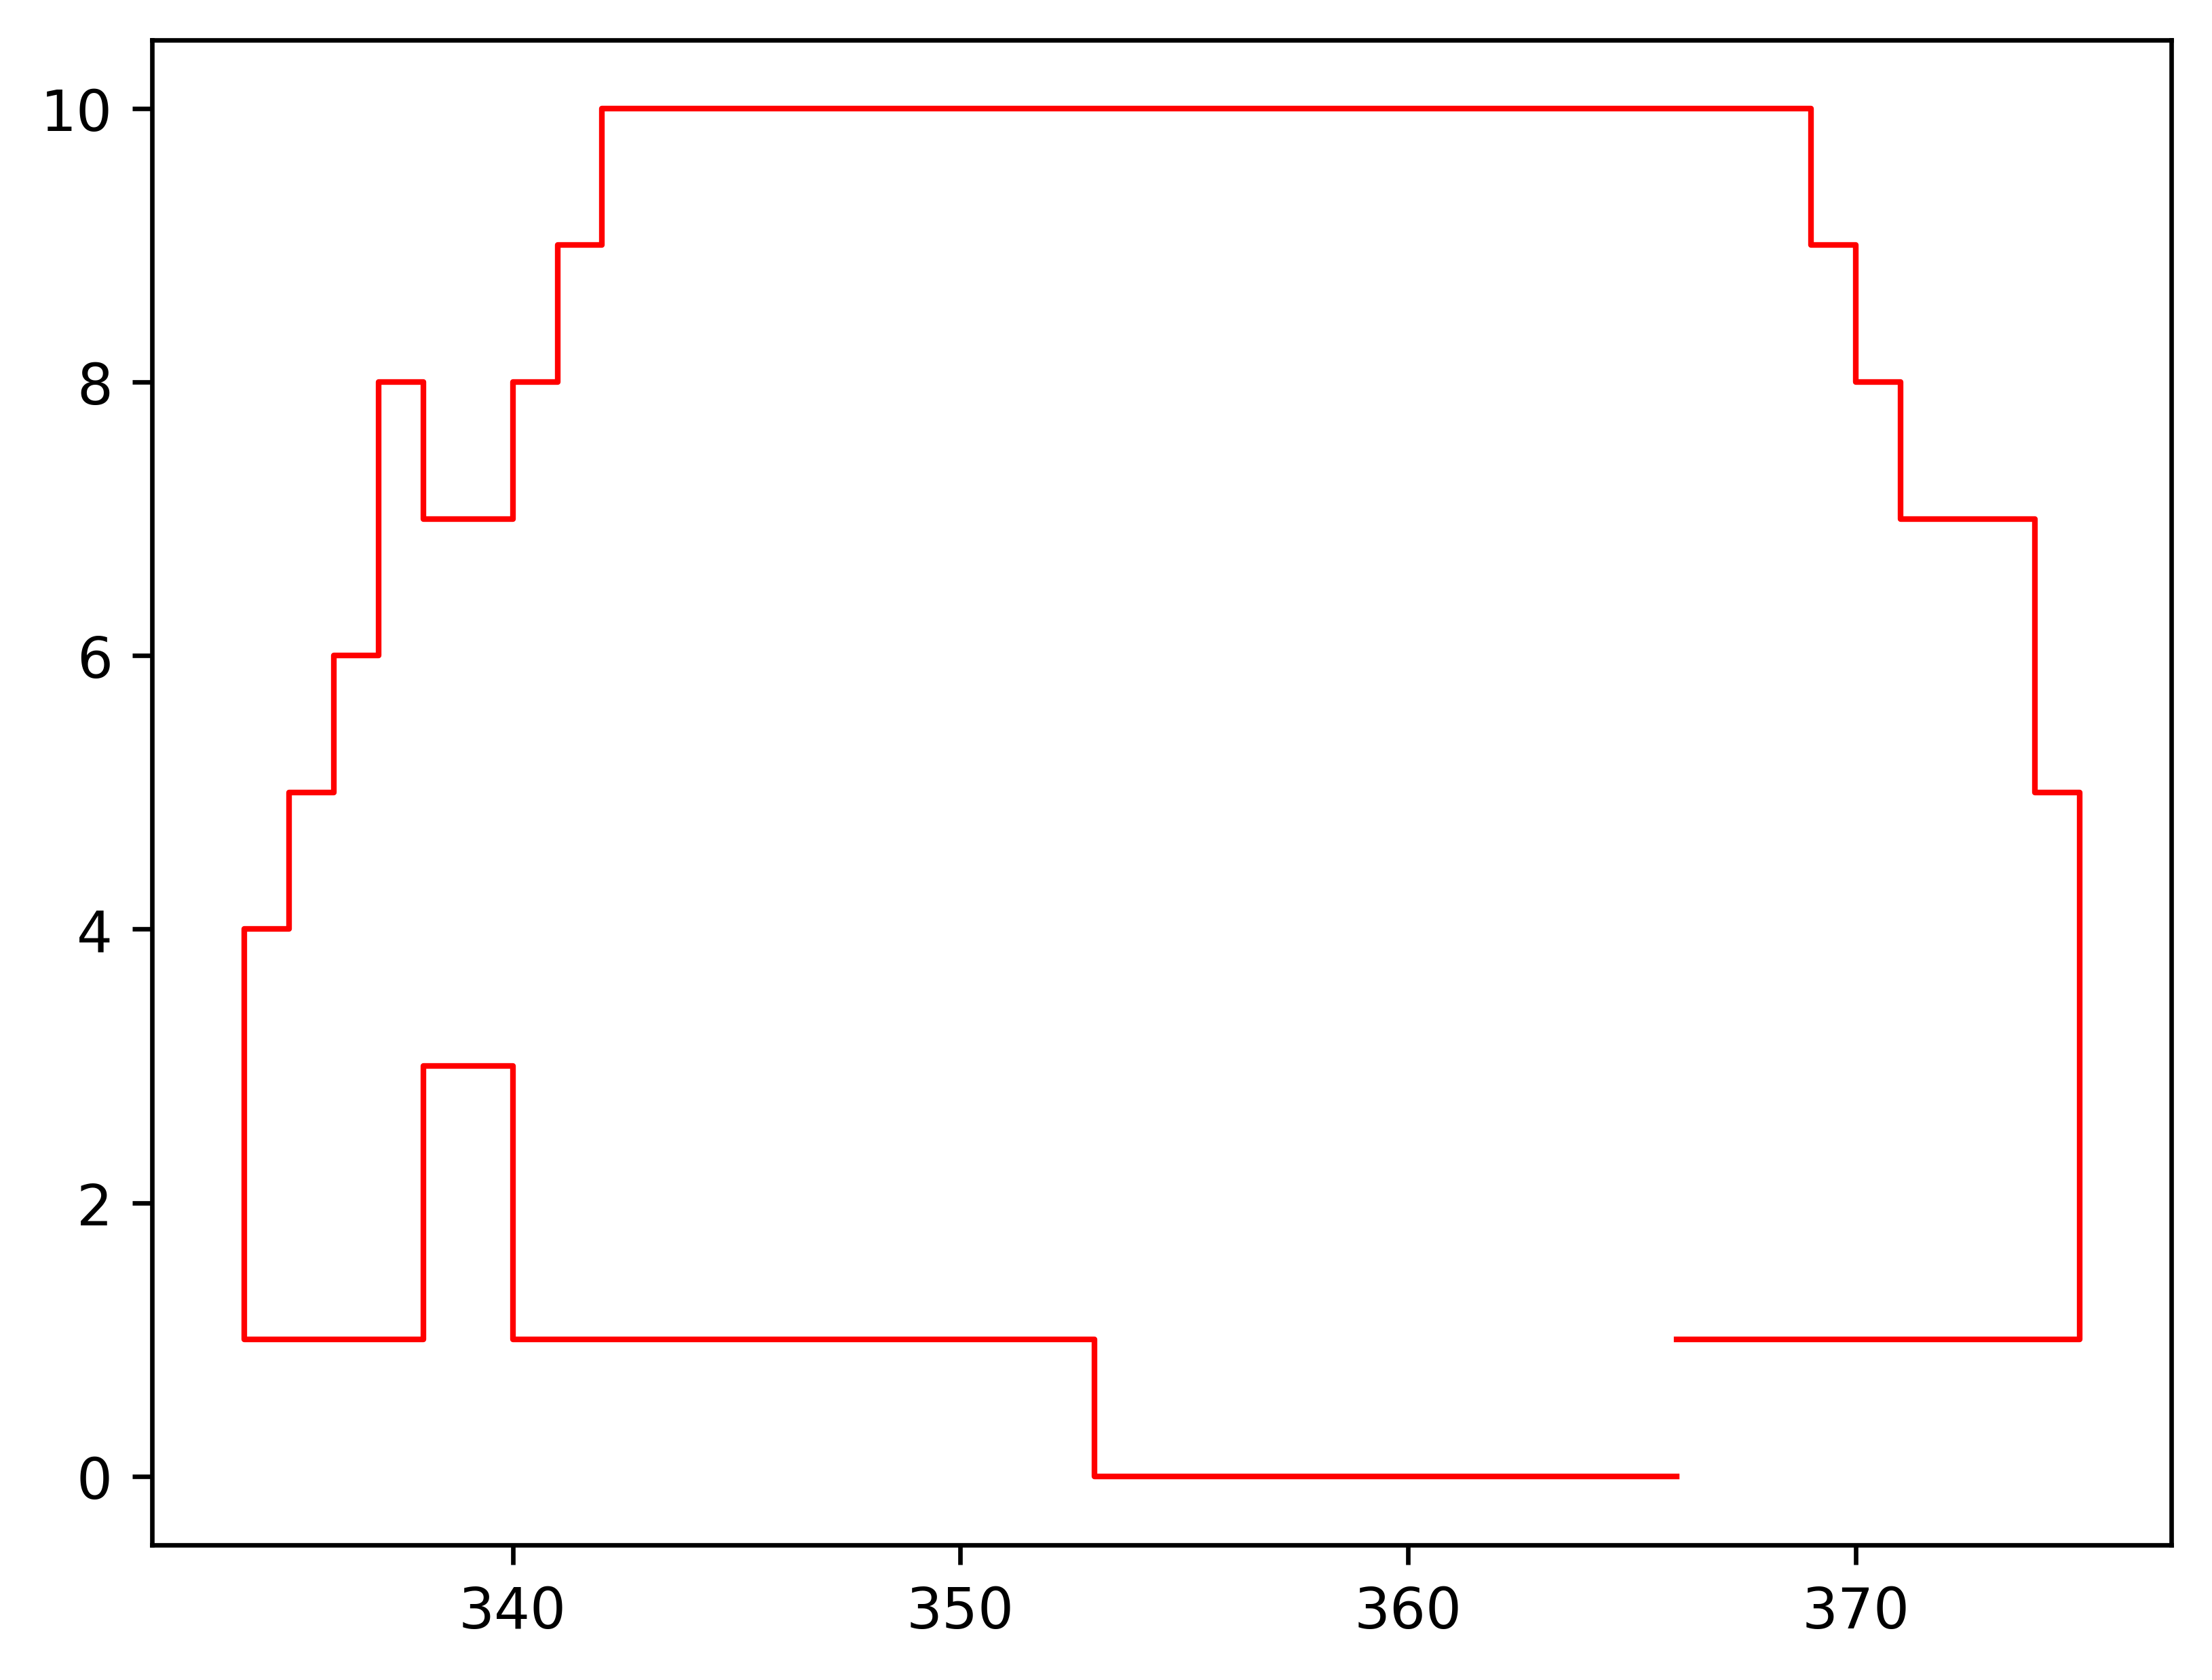

In [ ]:
roiContour(roi, '001')

In [ ]:
def get_curve(roi: dict[str, list[int]]):
    """
    Return ROI Curve for an image using geomstats backend
    
    Parameters
    ----------
    roi : dict, Cell Number as the key, coordinates as xy
    """
    curves = []
    for cell in roi.keys():
        curves.append(np.column_stack((roi[cell]['x'], roi[cell]['y'])))
    return curves


In [ ]:
img_roi = get_curve(roi)
len(img_roi)

196

Text(0.5, 1.0, 'Verify ROI Curve')

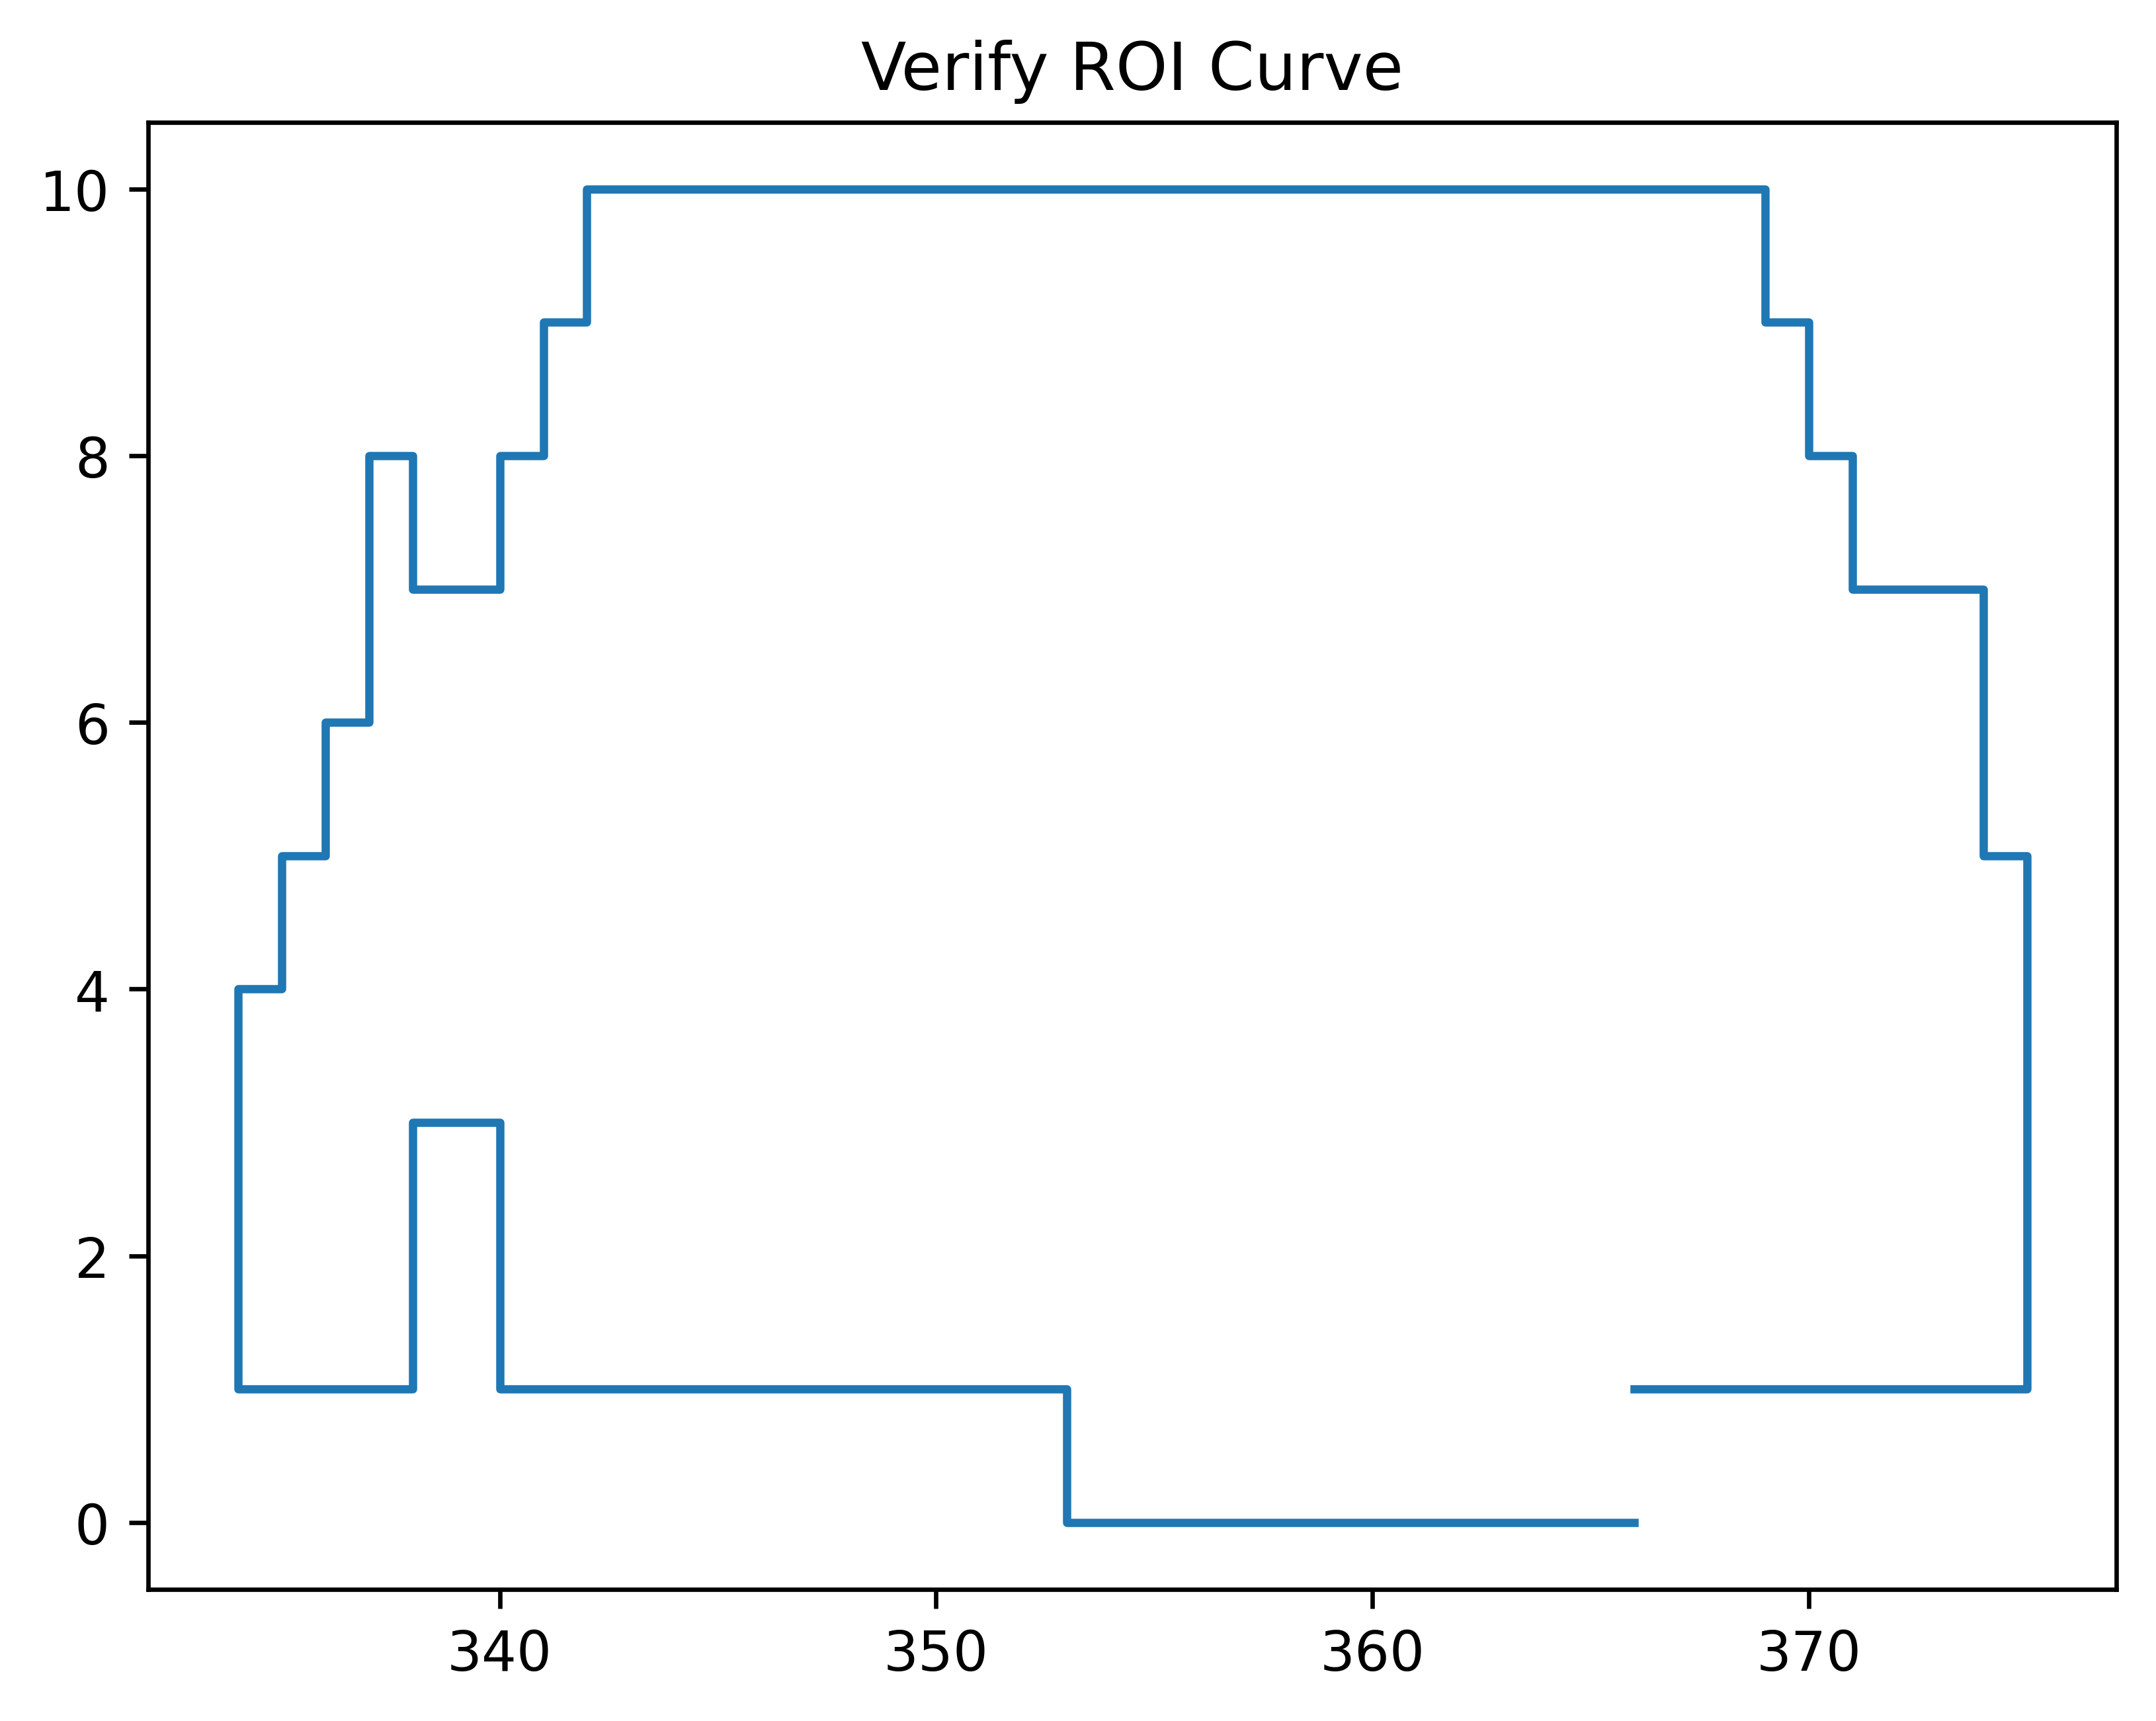

In [ ]:
# Verify that get_curve correctly parsed the rois
test_roi = img_roi[0]
plt.plot(test_roi[:,0], test_roi[:,1])
plt.title("Verify ROI Curve")

In [ ]:
def interpolate_dicrete_curve(curve, n_sampling_points):
    """
    Interpolate a discrete curve so that it gets a given number of sampling points.

    Parameters
    ----------
    curve : array-like, shape=[n_points, 2]
    n_sampling_points : int
    
    Returns
    -------
    interpolation : array-like, shape=[n_sampling_points, 2]
       Discrete curve with n_sampling_points
    """
    old_length = curve.shape[0]
    interpolation = np.zeros((n_sampling_points, 2))
    incr = old_length / n_sampling_points
    pos = np.array(0.0, dtype=np.float32)
    for i in range(n_sampling_points):
        index = int(np.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return gs.array(interpolation, dtype=gs.float32)

In [ ]:
r2 = Euclidean(2)

planar_curves_space = DiscreteCurves(r2)

result = planar_curves_space.belongs(img_roi)
gs.all(result)

True

#### Curve Interpolation
Here we illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one.

(382.9839859008789, 407.0960006713867, 87.45, 121.55)

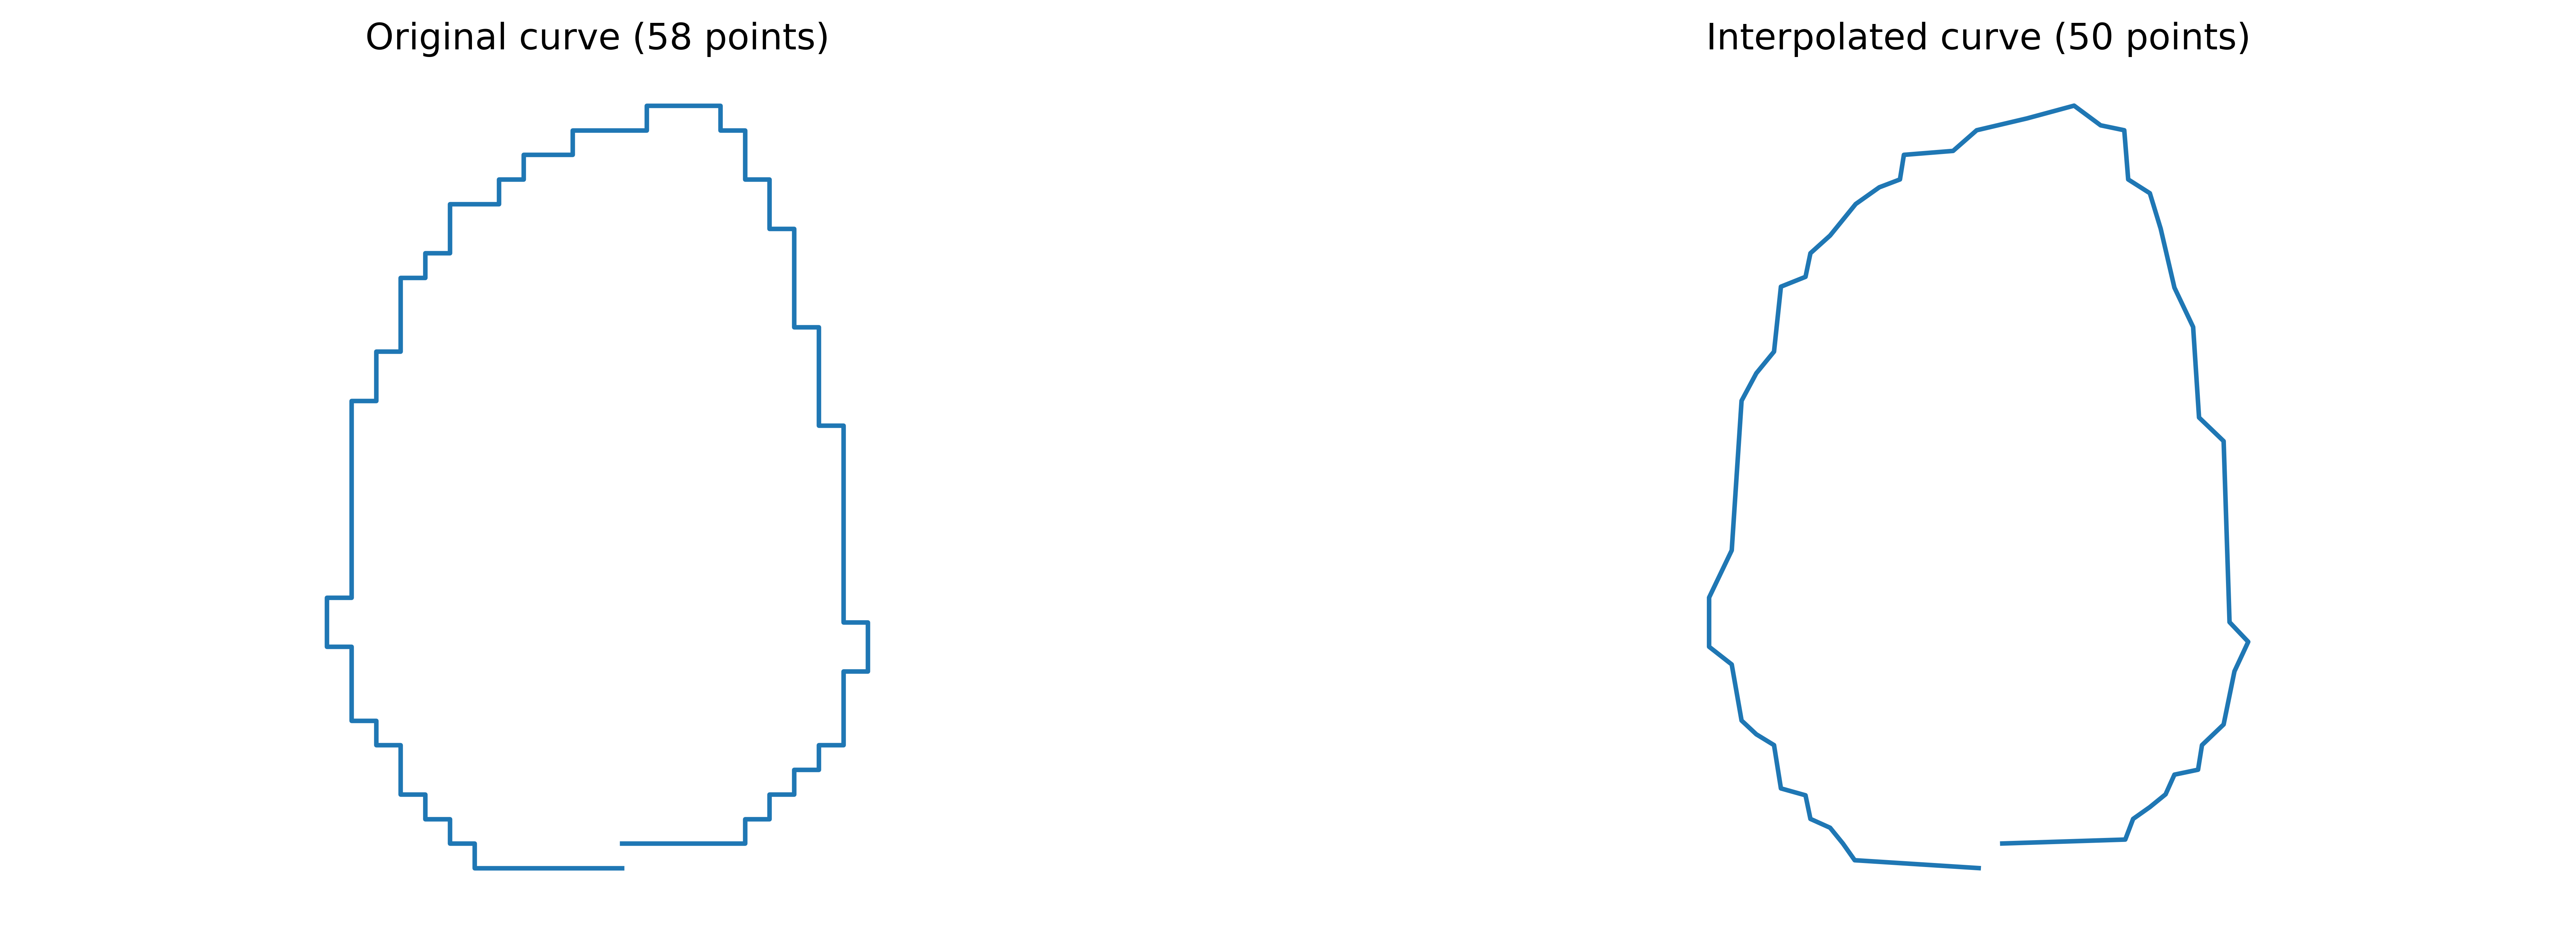

In [ ]:
k_sampling_points = 50

cell_rand = img_roi[gs.random.randint(len(img_roi))]
cell_interpolation = interpolate_dicrete_curve(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

---

# We need to ensure there are no duplicate sampling points in our shapes

In [ ]:
#Code snippet to remove identical consecutive sampling points, provided by Prof. Nina Miolane
def _remove_consecutive_duplicates(curve, tol=1e-2):
    """Preprocess curve to ensure that there are no consecutive and identical sampling points.

    Returns
    -------
    curve : discrete curve
    """
    dist = curve[1:] - curve[:-1]
    dist_norm = gs.sqrt(gs.sum(dist**2, axis=1))

    if gs.any(dist_norm < tol):
        for i in range(len(curve) - 2):
            if gs.sqrt(gs.sum((curve[i + 1] - curve[i]) ** 2, axis=0)) < tol:
                curve[i + 1] = (curve[i] + curve[i + 2]) / 2

    return curve

---

# 🤖🔥 THATS ALL FOR NOW! 🔥🤖

🚀 If you found this notebook useful, don't forget to star this repo and the `geomstats` repo as well! 